# 2D seismicity Plot 

##  Ryota Kiuchi
https://sites.google.com/view/rkiuchi/home

https://www.linkedin.com/in/ryota-kiuchi-b121819b/

#### Examples
#### - 2018 Osaka-Hokubu earthquake (M 6.1) aftershock activity
#### - 2019 Yamagata-oki earthquake (M 6.7) aftershock activity
#### made by R.Kiuchi June, 2018

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.mlab as mlab
import numpy as np
import matplotlib.cm as cm
import pandas as pd
import matplotlib.colors as mcol
import matplotlib as mpl
from matplotlib import animation
from mpl_toolkits.basemap import Basemap
import os
import glob
from obspy.imaging.beachball import beach


from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, SelectionRangeSlider

# Setting the directory
homedir = os.getcwd()
outdir = homedir + '/results' 


## Import JMA event catalog

In [2]:
# Setting the directory
datadir = homedir + '/data'

###############----For input----###############
file_list = glob.glob(datadir + '/JMAcatalog/h19*.csv')
file_list.extend(glob.glob(datadir + '/JMAcatalog/h20*.csv'))

for i in range(len(file_list)):
    eachdata = pd.read_csv(file_list[i])
    if (i == 0):
        JMAdata = eachdata
    else:
        JMAdata = pd.concat([JMAdata, eachdata])


# Data selection
JMAdata = JMAdata[JMAdata.Mag >= 1]
'''
JMAdata = JMAdata[JMAdata.Evla >= 34.5]
JMAdata = JMAdata[JMAdata.Evla < 35.25]
JMAdata = JMAdata[JMAdata.Evlo >= 135.25]
JMAdata = JMAdata[JMAdata.Evlo < 136]
JMAdata = JMAdata[JMAdata.Depth < 50]
'''
# Change format to datetime for event date
JMAdata.EventID=pd.to_datetime(JMAdata.DateTime,format='%Y%m%d%H%M%S')

JMA_date = np.array(JMAdata['DateTime'])
JMA_evlon = np.array(JMAdata['Evlo'])
JMA_evlat = np.array(JMAdata['Evla'])
JMA_evDepth = np.array(JMAdata['Depth'])
JMA_evMag = np.array(JMAdata['Mag'])





## - Import the fault data

In [3]:
# Setting the directory
datadir = homedir + '/data'

path = datadir + '/fault.jpn.txt'
file = open(path)
fault_data = file.read().splitlines()
file.close

fault = np.zeros((3938, 10000, 2))

# Split multiple fault
j = -1
for i in range(len(fault_data)):
    if (fault_data[i] == '> '):
        j = j + 1
        column = i
    else:
        fault[j,i-column-1] = fault_data[i].split(' ')
        



# 20190618 Yamagata-oki EQ

## - Import the 2019 Yamagata-oki event catalog

In [4]:
# Setting the directory
datadir = homedir + '/data/2019Yamagata-oki'

file_list = glob.glob(datadir + "/HinetHypo.csv")
for i in range(len(file_list)):
    eachdata = pd.read_csv(file_list[i])
    if (i == 0):
        data = eachdata
    else:
        data = pd.concat([data, eachdata])

    
# Data fill NaN for empty cells
data.replace('', np.nan, inplace=True)


# Data selection
#data = data[data.Depth > 9] 

'''
data = data[data.Depth <= 30]        
data = data[data.Evla >= 34.7]
data = data[data.Evla < 35.0]
data = data[data.Evlo >= 135.45]
data = data[data.Evlo < 135.75]
'''
data['Mag'] = data['Mag'].str.strip('v')
data['Mag'] = data['Mag'].str.strip('V')
data['Mag'] = data['Mag'].str.strip('D')
data['Mag'] = data['Mag'].astype(float)
data = data[data.Mag >= 1.0]

# Change format to datetime for event date
# from Hi-net data source
data.DateTime=pd.to_datetime(data.DateTime, format='%Y-%m-%d %H:%M:%S')

date = np.array(data['DateTime'])
evlon = np.array(data['Evlo'])
evlat = np.array(data['Evla'])
evDepth = np.array(data['Depth'])
evMag = np.array(data['Mag'])


# Calculate time difference from Foreshock and Mainshock
MshockTime = date[np.where(evMag == 6.7)]
Timefrom_Mshock = (date - MshockTime)/np.timedelta64(1,'h')

### Data filtering
# For time from mainshock
# Hours before and after mainshock
Before = 0
After = 48
date = date[np.where(Timefrom_Mshock >= Before)]
evlon = evlon[np.where(Timefrom_Mshock >= Before)]
evlat = evlat[np.where(Timefrom_Mshock >= Before)]
evMag = evMag[np.where(Timefrom_Mshock >= Before)]
evDepth = evDepth[np.where(Timefrom_Mshock >= Before)]
Timefrom_Mshock = Timefrom_Mshock[np.where(Timefrom_Mshock >= Before)]

date = date[np.where(Timefrom_Mshock <= After)]
evlon = evlon[np.where(Timefrom_Mshock <= After)]
evlat = evlat[np.where(Timefrom_Mshock <= After)]
evMag = evMag[np.where(Timefrom_Mshock <= After)]
evDepth = evDepth[np.where(Timefrom_Mshock <= After)]
Timefrom_Mshock = Timefrom_Mshock[np.where(Timefrom_Mshock <= After)]



/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


## - Static 2D hypocentral distribution map

<IPython.core.display.Javascript object>


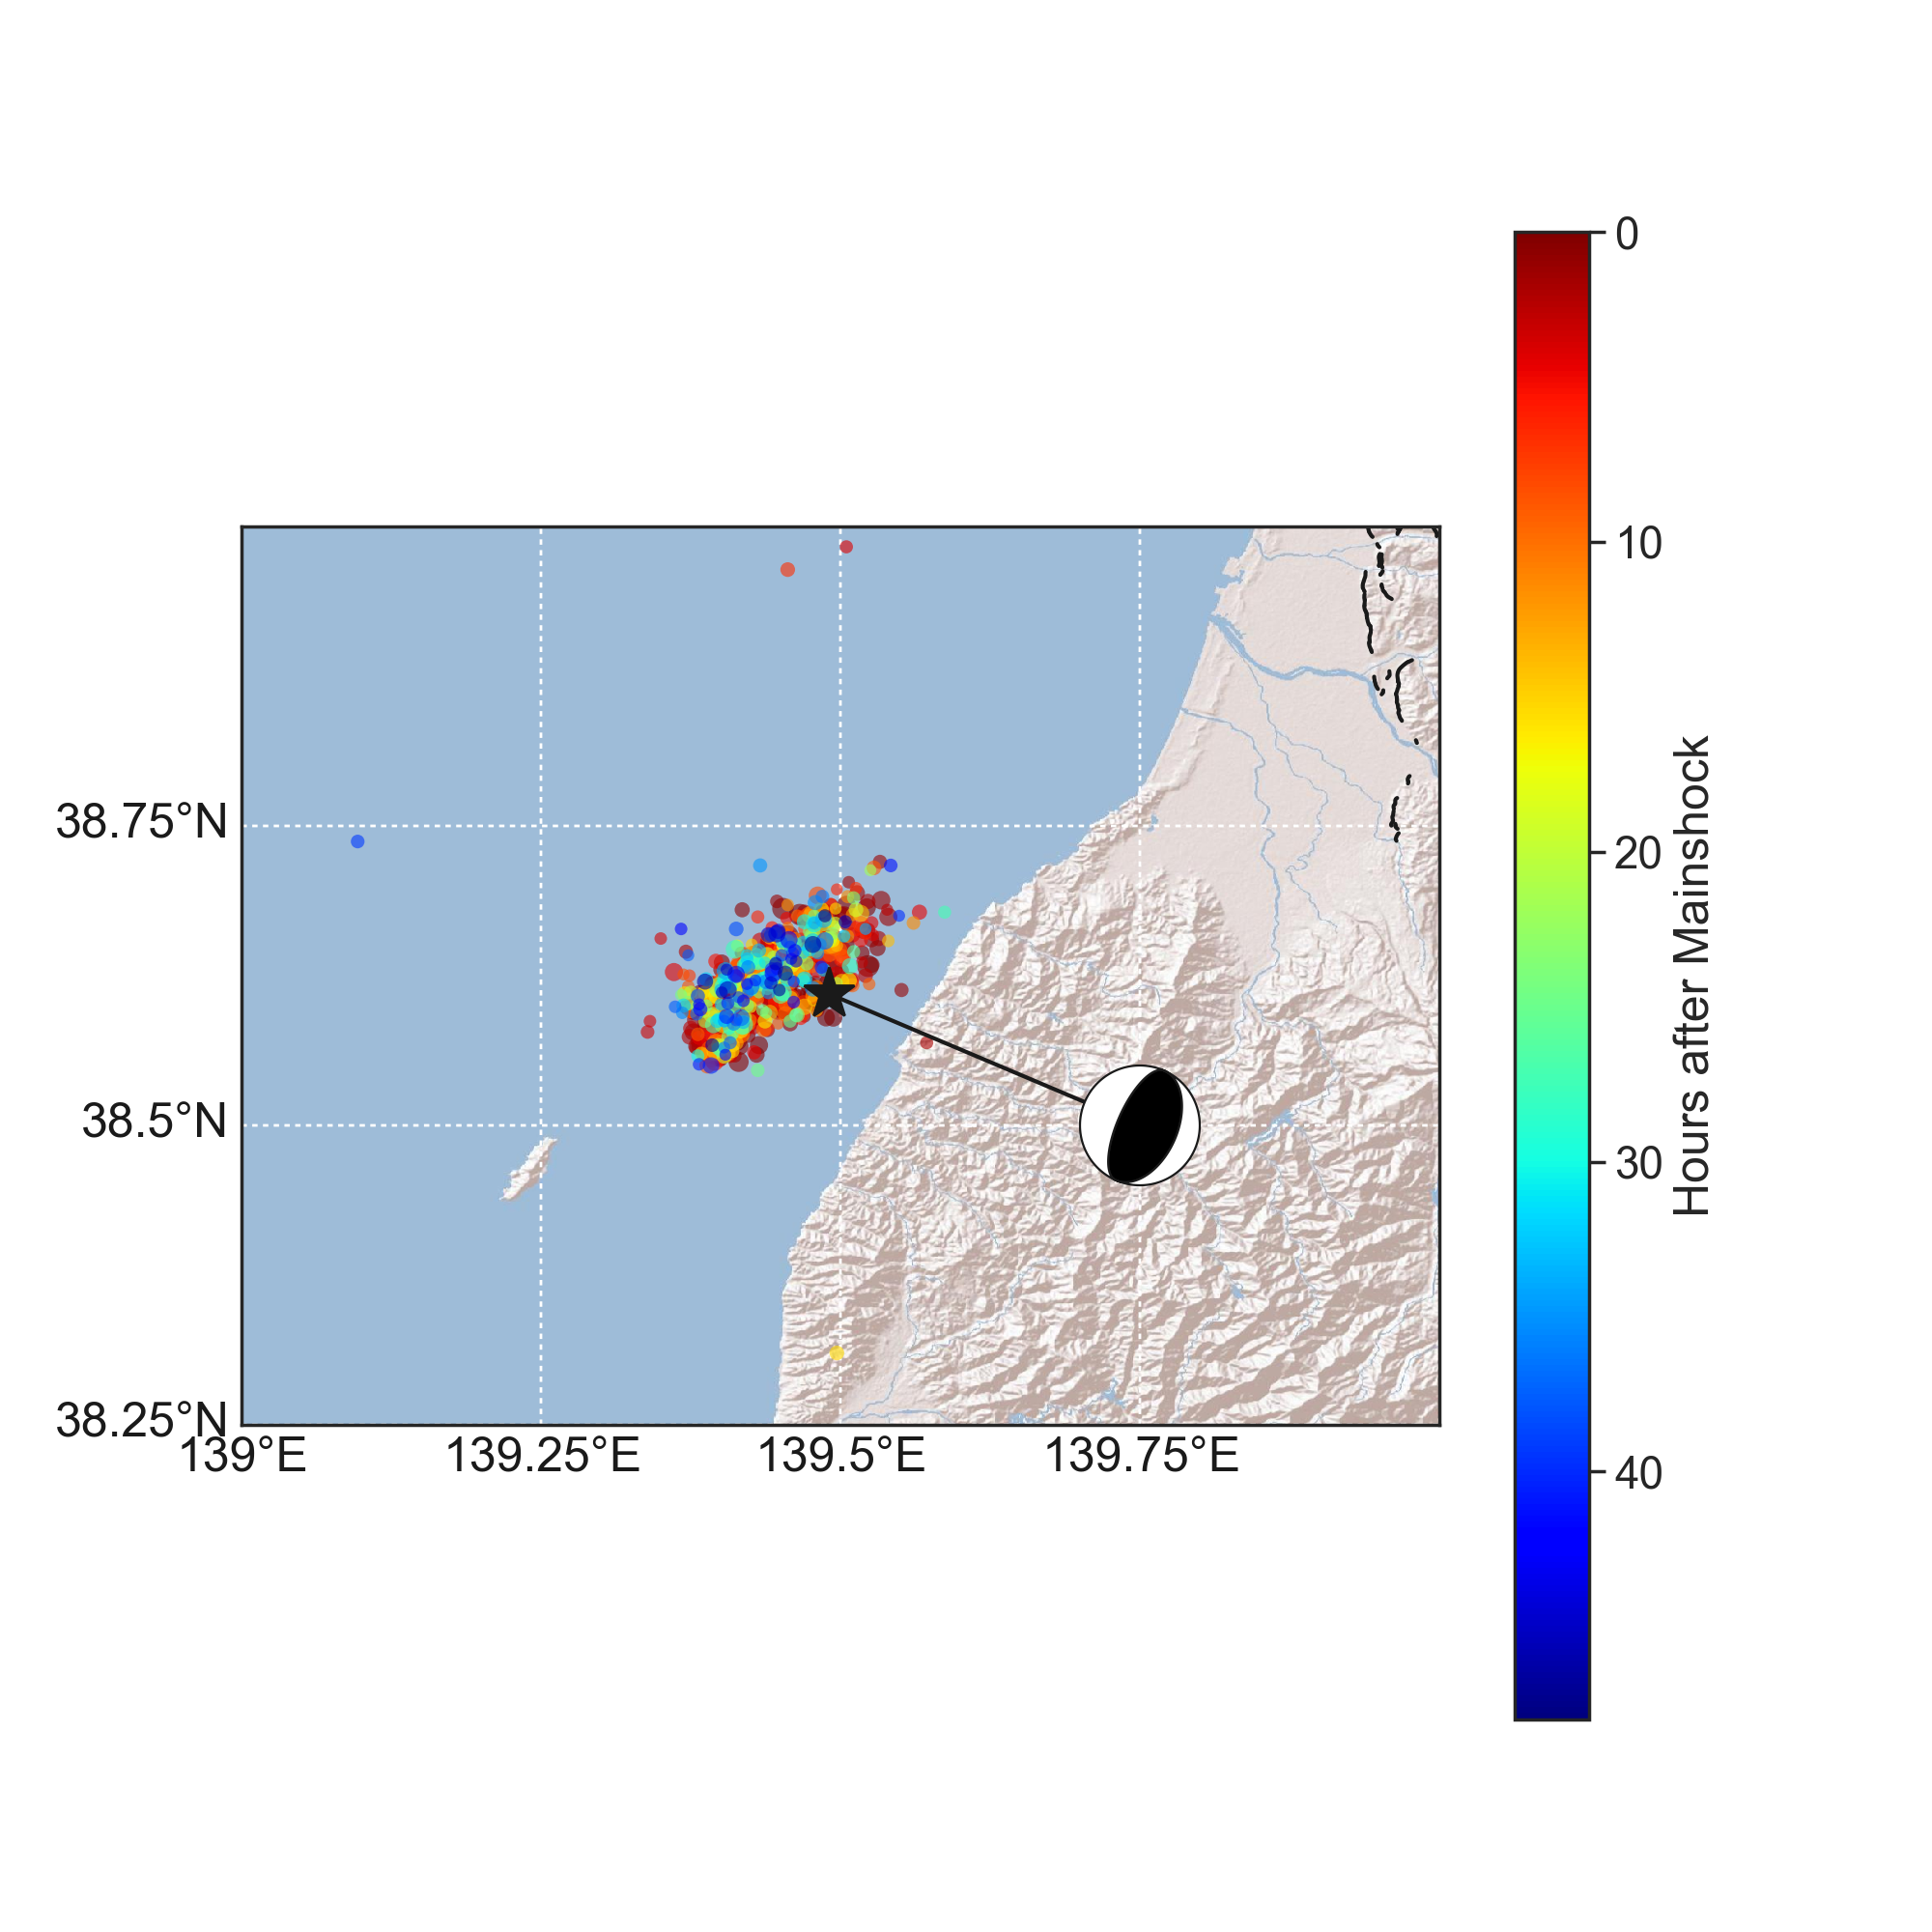

http://server.arcgisonline.com/ArcGIS/rest/services/World_Shaded_Relief/MapServer/export?bbox=139.0,38.25,140.0,39.0&bboxSR=4326&imageSR=4326&size=1500,1125&dpi=96&format=png32&transparent=true&f=image


In [5]:
import seaborn as sns 

# Import Seaborn style
sns.set(style='ticks', font_scale=1.5)

# Range of map
'''
lonmin = 138.5
lonmax = 140.5
lonbin = 1.0
latmin = 37.5
latmax = 39.5
latbin = 1.0
'''
lonmin = 139.
lonmax = 140.
lonbin = 0.25
latmin = 38.25
latmax = 39.
latbin = 0.25


###############----Draw the basemap----###############

fig = plt.figure(figsize=(10,10))


map = Basemap(projection='merc',llcrnrlat=latmin,urcrnrlat=latmax,
              llcrnrlon=lonmin,urcrnrlon=lonmax,lat_ts=5,resolution='h')
#map.fillcontinents(color='#DDDDDD',zorder=0)
#map.drawlsmask(land_color='0.4',resolution='h')


map = Basemap(llcrnrlon=lonmin,llcrnrlat=latmin,urcrnrlon=lonmax,urcrnrlat=latmax)
#http://server.arcgisonline.com/arcgis/rest/services
#map.arcgisimage(service='ESRI_Imagery_World_2D', xpixels = 1500, verbose= True)
map.arcgisimage(service='World_Shaded_Relief', xpixels = 1500, verbose= True)

###############----Draw the basemap----###############

# Set input parameters for showing the map
#x, y = map(stlon, stlat)
x, y = map(evlon, evlat)
# For color
'''
color = evDepth
cmin = 0; cmax = 20.; cbin = 0.5; clabel = 'Depth [km]'
cticks=np.linspace(cmin,cmax,5)
'''
color = Timefrom_Mshock
cmin = 0; cmax = 48.; cbin = 1.; clabel = 'Hours after Mainshock'
cticks=np.arange(cmin,cmax+10,10)

size = evMag * 20    # For plot size
#size = 2


# Set the color palette
#cpalette = cm.seismic
cpalette = cm.get_cmap('jet_r')


# Add paralles and meridians
parallels = np.arange(latmin,latmax,lonbin)
meridians = np.arange(lonmin,lonmax,latbin)
map.drawparallels(parallels,labels=[1,0,0,0], dashes=[2,2], zorder=1, color='white')
map.drawmeridians(meridians,labels=[0,0,0,1], dashes=[2,2], zorder=1, color='white')


# Add fault trace
for i in range(fault.shape[0]):
    floc = fault[i][np.where(fault[i]!=0)]
    floc = np.reshape(floc, (int(len(floc)/2), 2))
    fx, fy = map(floc[:,0], floc[:,1])
    map.plot(fx, fy, 'k-', zorder=1)
    #map.scatter(fx, fy, s=100, lw=0,  antialiased=True) 


###############----plot the data----###############
map.scatter(x, y, s=size, c=color, cmap=cpalette, alpha=0.6, lw=0,  antialiased=True, zorder=3)


### Mainshock of 20190618 Niigata
bx, by = map(139.49, 38.61)
map.plot(bx, by, 'k*', linewidth=5, markersize=20, zorder=10)
ax = plt.gca()
pbx, pby = map(139.75, 38.5)
D = 12.0
fmech = [204.0, 56.6, 90.0]
ax = plt.gca()
# If you don't choose arcgis image for map
#b = beach(fmech, xy=(pbx, pby), facecolor='black', width=2e4, linewidth=0.8, alpha=1.0)
# If you choose arcgis image for map
b = beach(fmech, xy=(pbx, pby), facecolor='black', width=0.1, linewidth=0.8, alpha=1.0)
b.set_zorder(10)
ax.add_collection(b)
# Add lines
map.plot([bx,pbx],[by,pby], 'k-', zorder=3)


### Color bar
plt.clim(cmin,cmax)
cb = plt.colorbar(label=clabel, orientation = 'vertical', ticks=cticks)
cb.set_alpha(1)
cb.draw_all()
cb.ax.invert_yaxis()


plt.show()

plt.savefig(outdir + "/20190618Yamagata-okiEQ2D.png")





## - Timelapse

<IPython.core.display.Javascript object>


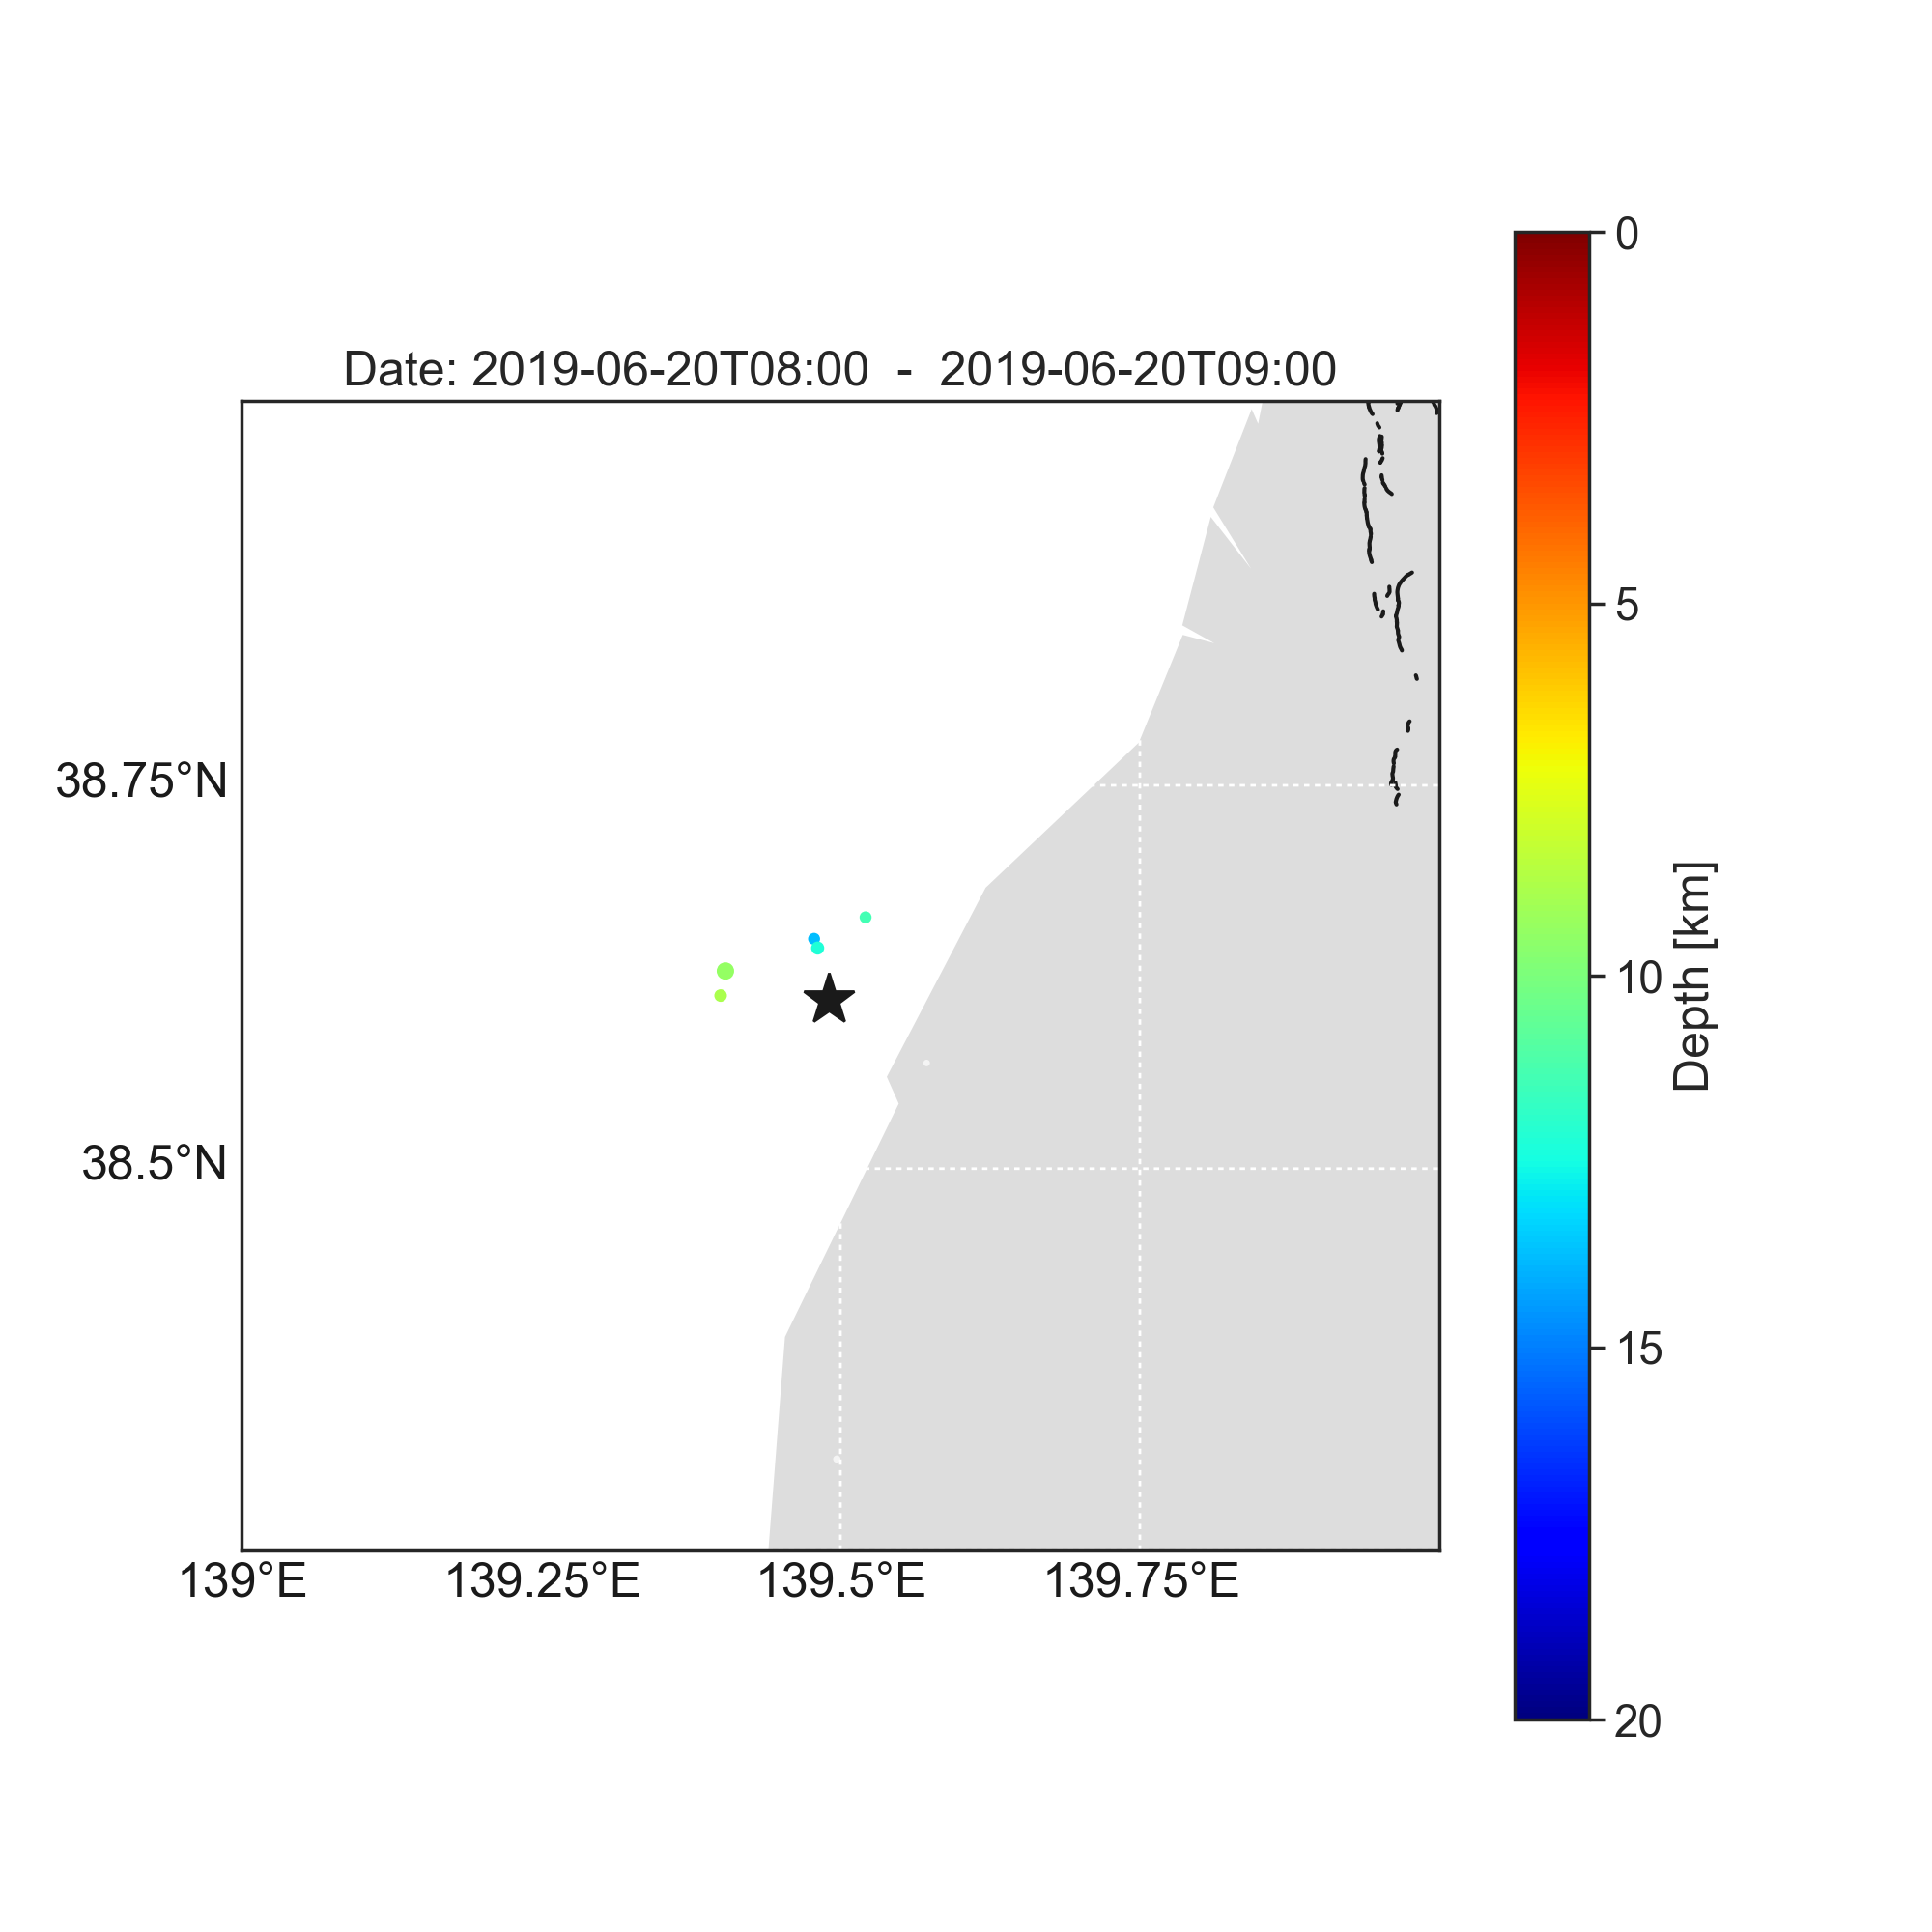

In [6]:
def draw2DMap(i, date, evlon, evlat, evDepth, evMag, Timefrom_Mshock):
    
    # Delete current graph
    plt.clf()

    # Data selection
    # Select the date range
    Dstart = np.datetime64('2019-06-18T22:00:00.000000000')
    Dend = np.datetime64('2019-06-20T22:00:00.000000000')

    Dbin = 1
    Dnum = int((Dend - Dstart)/np.timedelta64(Dbin,'h'))

    d1 = Dstart + np.timedelta64(Dbin*i,'h')
    d2 = d1 + np.timedelta64(Dbin,'h')
    
    select = np.where((date >= d1) & (date < d2))
    old = np.where(date < d1)
    # Data within setting bin
    datebin = date[select]
    evlonbin = evlon[select]
    evlatbin = evlat[select]
    evDepthbin = evDepth[select]
    evMagbin = evMag[select]
    Timefrom_Mshockbin = Timefrom_Mshock[select]
    # Data before setting bin
    evlonold = evlon[old]
    evlatold = evlat[old]
    evDepthold = evDepth[old]
    evMagold = evMag[old]
    Timefrom_Mshockold = Timefrom_Mshock[old]
    
    ###############----Add transparency animation----###############
    '''
    # transparency factor
    if (i > 0):
        num_trans = 10
        i = i %(2*num_trans)
        trans = (abs(num_trans - i) % num_trans)/num_trans
    if (i == 0):
        trans = 1
    elif (i == num_trans):
        trans = (abs(num_trans - (i-1)) % num_trans)/num_trans
    '''
    

    ###############----Draw the basemap----###############
    map = Basemap(projection='merc',llcrnrlat=latmin,urcrnrlat=latmax,
                  llcrnrlon=lonmin,urcrnrlon=lonmax,lat_ts=5,resolution='i')
    map.fillcontinents(color='#DDDDDD',zorder=0)
    #map.drawlsmask(land_color='0.4',resolution='h')

    #map = Basemap(llcrnrlon=lonmin,llcrnrlat=latmin,urcrnrlon=lonmax,urcrnrlat=latmax)
    #http://server.arcgisonline.com/arcgis/rest/services

    #map.arcgisimage(service='ESRI_Imagery_World_2D', xpixels = 1500, verbose= True)
    #map.arcgisimage(service='World_Shaded_Relief', xpixels = 1500, verbose= True)

    ###############----Draw the basemap----###############

    x, y = map(evlonbin, evlatbin)
    # For color
    # For color
    color = evDepthbin
    colorold = evDepthold
    cmin = 0; cmax = 20.; cbin = 0.5; clabel = 'Depth [km]'
    cticks=np.linspace(cmin,cmax,5)
    '''
    color = Timefrom_Mshockbin
    colorold = Timefrom_Mshockold
    cmin = 0; cmax = 50.; cbin = 1.; clabel = 'Hours after Mainshock'
    cticks=np.arange(cmin,cmax+10,10)
    '''
    size = evMagbin * 20    # For plot size
    #size = 10
    
    xold, yold = map(evlonold, evlatold)    
    sizeold = evMagold * 5    # For plot size
    #sizeold = 4

    # Set the color palette
    cpalette = cm.get_cmap('jet_r')
    norm = mcol.BoundaryNorm(np.arange(cmin,cmax,cbin), cpalette.N)    # For discrete color palette

    # Add paralles and meridians
    
    parallels = np.arange(latmin,latmax,latbin)
    meridians = np.arange(lonmin,lonmax,lonbin)
    map.drawparallels(parallels,labels=[1,0,0,0], dashes=[2,2], color='white')
    map.drawmeridians(meridians,labels=[0,0,0,1], dashes=[2,2], color='white')
    
    # Add fault trace
    for i in range(fault.shape[0]):
        floc = fault[i][np.where(fault[i]!=0)]
        floc = np.reshape(floc, (int(len(floc)/2), 2))
        fx, fy = map(floc[:,0], floc[:,1])
        map.plot(fx, fy, 'k-', zorder=1)

    ###############----plot the data----###############
    #map.scatter(xold, yold, s=sizeold, c=colorold, cmap=cpalette, alpha=1.0, lw=0,  antialiased=True) 
    map.scatter(xold, yold, s=sizeold, c='white', alpha=0.7, lw=0,  antialiased=True, zorder=1) 
    map.scatter(x, y, s=size, c=color, cmap=cpalette, alpha=1.0, lw=0,  antialiased=True, zorder=10) 
    # alpha is transparency through 0 to 1(solid)

    # Plot Mainshock
    bx, by = map(139.49, 38.61)
    map.plot(bx, by, 'k*', linewidth=5, markersize=20, zorder=3)
    
    plt.clim(cmin,cmax)
    cb = plt.colorbar(label=clabel, orientation = 'vertical', ticks=np.linspace(0,20,5))
    #cb.set_alpha(1)
    #cb.draw_all()
    cb.ax.invert_yaxis()
    plt.title('Date: ' + str(d1.astype('M8[m]')) + '  -  ' + str(d2.astype('M8[m]')))

fig = plt.figure(figsize=(10,10))

Dstart = np.datetime64('2019-06-18T22:00:00.000000000')
Dend = np.datetime64('2019-06-20T22:00:00.000000000')

Dbin = 1
Dnum = int((Dend - Dstart)/np.timedelta64(Dbin,'h'))

ani = animation.FuncAnimation(fig, draw2DMap, fargs=(date, evlon, evlat, evDepth, evMag, Timefrom_Mshock),
                              interval=100, frames=Dnum)
ani.save(outdir + '/2019Yamagata-oki_2DTLapse.mp4', fps=2, dpi=200)
plt.show()

# 2018 Osaka EQ

## - Import the 2018 Osaka event catalog

In [5]:
# Setting the directory
datadir = homedir + '/data/2018Osaka'

file_list = glob.glob(datadir + "/HinetHypo.csv")
for i in range(len(file_list)):
    eachdata = pd.read_csv(file_list[i])
    if (i == 0):
        data = eachdata
    else:
        data = pd.concat([data, eachdata])
        
        
# Data selection
#data = data[data.Depth > 9] 

'''
data = data[data.Depth <= 30]        
data = data[data.Evla >= 34.7]
data = data[data.Evla < 35.0]
data = data[data.Evlo >= 135.45]
data = data[data.Evlo < 135.75]
'''
data = data[data.Mag >= 1.0]

# Change format to datetime for event date
# from Hi-net data source
data.DateTime=pd.to_datetime(data.DateTime, format='%Y-%m-%d %H:%M:%S')

date = np.array(data['DateTime'])
evlon = np.array(data['Evlo'])
evlat = np.array(data['Evla'])
evDepth = np.array(data['Depth'])
evMag = np.array(data['Mag'])


# Calculate time difference from Foreshock and Mainshock
MshockTime = date[np.where(evMag == 6.2)]
Timefrom_Mshock = (date - MshockTime)/np.timedelta64(1,'h')

### Data filtering
# For time from mainshock
Before = 0
After = 48
date = date[np.where(Timefrom_Mshock >= Before)]
evlon = evlon[np.where(Timefrom_Mshock >= Before)]
evlat = evlat[np.where(Timefrom_Mshock >= Before)]
evMag = evMag[np.where(Timefrom_Mshock >= Before)]
evDepth = evDepth[np.where(Timefrom_Mshock >= Before)]
Timefrom_Mshock = Timefrom_Mshock[np.where(Timefrom_Mshock >= Before)]

date = date[np.where(Timefrom_Mshock <= After)]
evlon = evlon[np.where(Timefrom_Mshock <= After)]
evlat = evlat[np.where(Timefrom_Mshock <= After)]
evMag = evMag[np.where(Timefrom_Mshock <= After)]
evDepth = evDepth[np.where(Timefrom_Mshock <= After)]
Timefrom_Mshock = Timefrom_Mshock[np.where(Timefrom_Mshock <= After)]




/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


## - Static 2D hypocentral distribution map

<IPython.core.display.Javascript object>


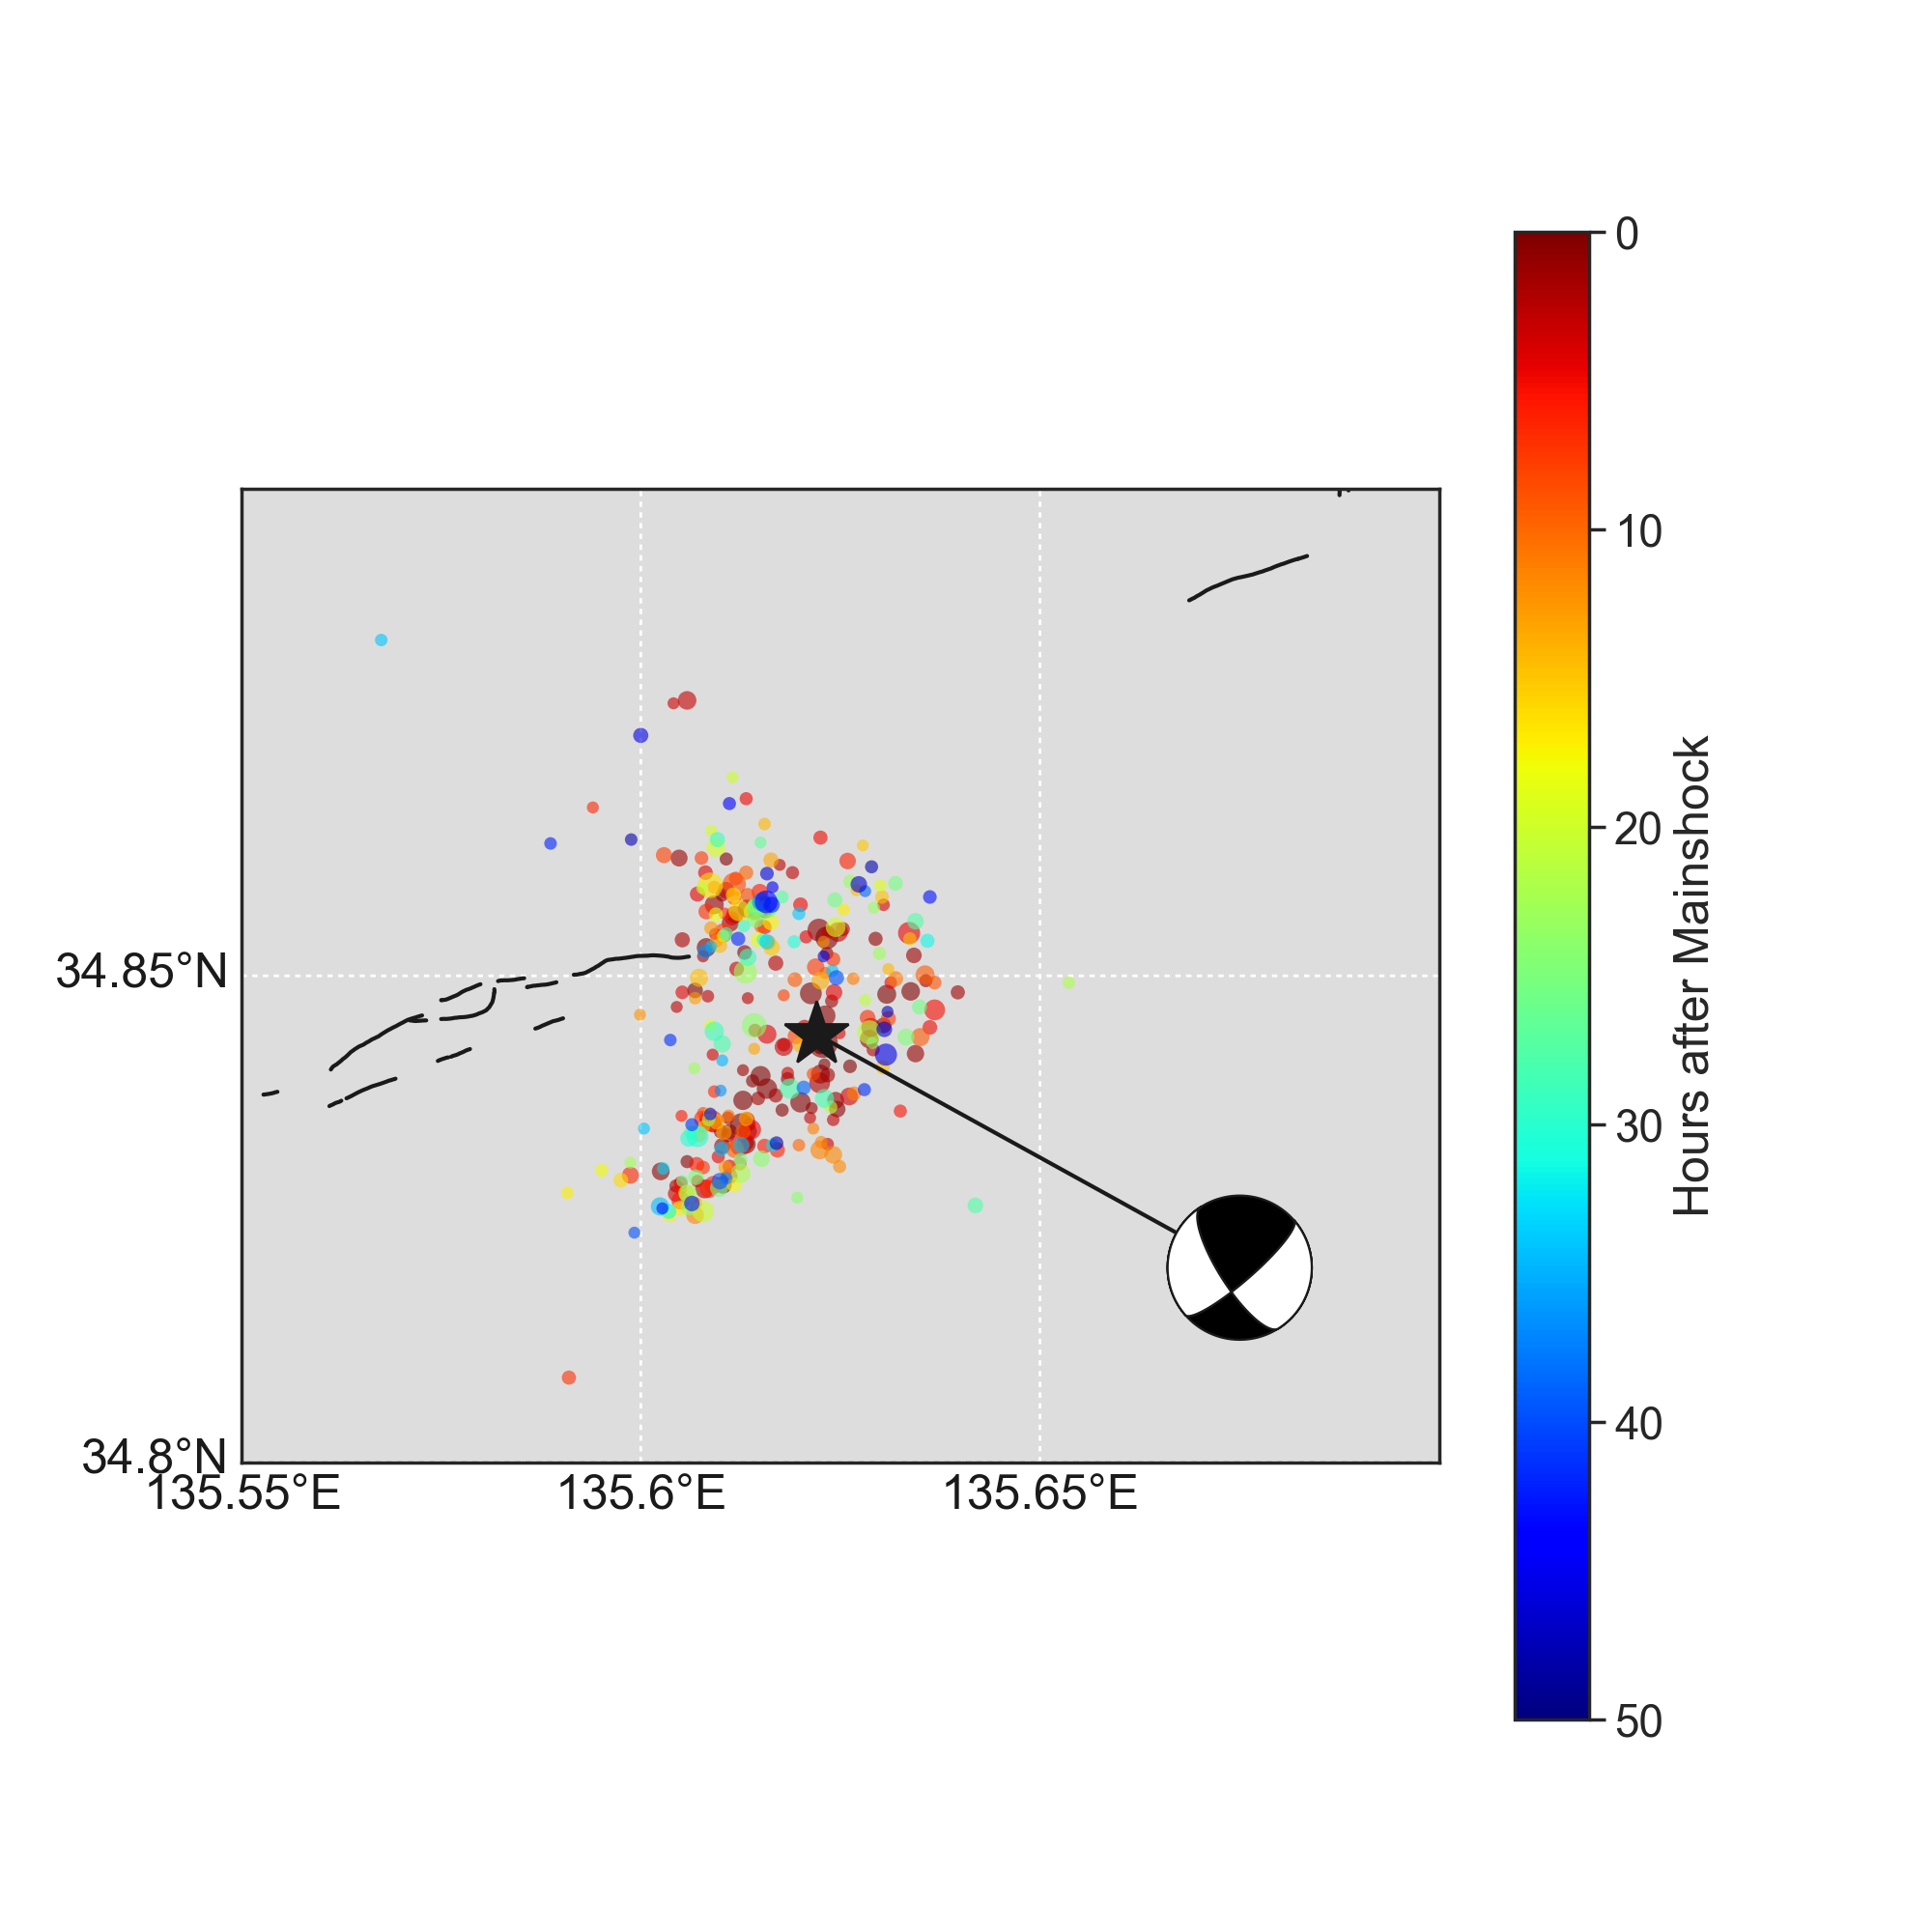

In [11]:
import seaborn as sns 

# Import Seaborn style
sns.set(style='ticks', font_scale=1.5)

# Range of map
# 2018Osaka
lonmin = 135.55
lonmax = 135.7
lonbin = 0.05
latmin = 34.8
latmax = 34.9
latbin = 0.05

# Set the color palette
#cpalette = cm.seismic
cpalette = cm.get_cmap('jet_r')


###############----Draw the basemap----###############

fig = plt.figure(figsize=(10,10))


map = Basemap(projection='merc',llcrnrlat=latmin,urcrnrlat=latmax,
              llcrnrlon=lonmin,urcrnrlon=lonmax,lat_ts=5,resolution='h')
map.fillcontinents(color='#DDDDDD',zorder=0)
#map.drawlsmask(land_color='0.4',resolution='h')


#map = Basemap(llcrnrlon=lonmin,llcrnrlat=latmin,urcrnrlon=lonmax,urcrnrlat=latmax)
#http://server.arcgisonline.com/arcgis/rest/services
#map.arcgisimage(service='ESRI_Imagery_World_2D', xpixels = 1500, verbose= True)
#map.arcgisimage(service='World_Shaded_Relief', xpixels = 1500, verbose= True)

###############----Draw the basemap----###############

# Set input parameters for showing the map
#x, y = map(stlon, stlat)
x, y = map(evlon, evlat)
# For color
'''
color = evDepth
cmin = 0; cmax = 20.; cbin = 0.5; clabel = 'Depth [km]'
cticks=np.linspace(cmin,cmax,5)
Depth_Main = 13.; c_Main = cpalette(Depth_Main/cmax)
'''
color = Timefrom_Mshock
cmin = 0; cmax = 50.; cbin = 1.; clabel = 'Hours after Mainshock'
cticks=np.arange(cmin,cmax+10,10)
Time_Main = 0.; c_Main = cpalette(Time_Main/cmax)

size = evMag * 20    # For plot size
#size = 2


# Add paralles and meridians
parallels = np.arange(latmin,latmax,lonbin)
meridians = np.arange(lonmin,lonmax,latbin)
map.drawparallels(parallels,labels=[1,0,0,0], dashes=[2,2], zorder=1, color='white')
map.drawmeridians(meridians,labels=[0,0,0,1], dashes=[2,2], zorder=1, color='white')


# Add fault trace
for i in range(fault.shape[0]):
    floc = fault[i][np.where(fault[i]!=0)]
    floc = np.reshape(floc, (int(len(floc)/2), 2))
    fx, fy = map(floc[:,0], floc[:,1])
    map.plot(fx, fy, 'k-', zorder=1)
    #map.scatter(fx, fy, s=100, lw=0,  antialiased=True) 


###############----plot the data----###############
map.scatter(x, y, s=size, c=color, cmap=cpalette, alpha=0.6, lw=0,  antialiased=True, zorder=3)


### Mainshock
bx, by = map(135.622, 34.844)
map.plot(bx, by, 'k*', linewidth=5, markersize=25, zorder=10)
ax = plt.gca()
pbx, pby = map(135.675, 34.82)
D = 12.0
fmech = [49., 73., 153.]
D = 13.
c = cpalette(D/cmax)
ax = plt.gca()
# If you don't choose arcgis image for map
b = beach(fmech, xy=(pbx, pby), facecolor='black', width=2e3, linewidth=0.8, alpha=1.0)
# If you choose arcgis image for map
#b = beach(fmech, xy=(pbx, pby), facecolor=list(c[0:3]), width=0.015, linewidth=0.8, alpha=1.0)
b.set_zorder(10)
ax.add_collection(b)
# Add lines
map.plot([bx,pbx],[by,pby], 'k-', zorder=3)


### Color bar
plt.clim(cmin,cmax)
cb = plt.colorbar(label=clabel, orientation = 'vertical', ticks=cticks)
cb.set_alpha(1)
cb.draw_all()
cb.ax.invert_yaxis()


plt.show()

plt.savefig(outdir + "/2018OsakaEQ2D.png")





## - Time Lapse

In [ ]:
def draw2DMap(i, date, evlon, evlat, evDepth, evMag, Timefrom_Mshock):
    
    # Delete current graph
    plt.clf()

    # Data selection
    # Select the date range
    Dstart = np.datetime64('2018-06-18T05:00:00.000000000')
    Dend = np.datetime64('2018-06-19T07:00:00.000000000')

    Dbin = 1
    Dnum = int((Dend - Dstart)/np.timedelta64(Dbin,'h'))

    d1 = Dstart + np.timedelta64(Dbin*i,'h')
    d2 = d1 + np.timedelta64(Dbin,'h')
    
    select = np.where((date >= d1) & (date < d2))
    old = np.where(date < d1)
    # Data within setting bin
    datebin = date[select]
    evlonbin = evlon[select]
    evlatbin = evlat[select]
    evDepthbin = evDepth[select]
    evMagbin = evMag[select]
    Timefrom_Mshockbin = Timefrom_Mshock[select]
    # Data before setting bin
    evlonold = evlon[old]
    evlatold = evlat[old]
    evDepthold = evDepth[old]
    evMagold = evMag[old]
    Timefrom_Mshockold = Timefrom_Mshock[old]
    
    ###############----Add transparency animation----###############
    '''
    # transparency factor
    if (i > 0):
        num_trans = 10
        i = i %(2*num_trans)
        trans = (abs(num_trans - i) % num_trans)/num_trans
    if (i == 0):
        trans = 1
    elif (i == num_trans):
        trans = (abs(num_trans - (i-1)) % num_trans)/num_trans
    '''
    

    ###############----Draw the basemap----###############
    map = Basemap(projection='merc',llcrnrlat=latmin,urcrnrlat=latmax,
                  llcrnrlon=lonmin,urcrnrlon=lonmax,lat_ts=5,resolution='i')
    map.fillcontinents(color='#DDDDDD',zorder=0)
    #map.drawlsmask(land_color='0.4',resolution='h')

    #map = Basemap(llcrnrlon=lonmin,llcrnrlat=latmin,urcrnrlon=lonmax,urcrnrlat=latmax)
    #http://server.arcgisonline.com/arcgis/rest/services

    #map.arcgisimage(service='ESRI_Imagery_World_2D', xpixels = 1500, verbose= True)
    #map.arcgisimage(service='World_Shaded_Relief', xpixels = 1500, verbose= True)

    ###############----Draw the basemap----###############

    x, y = map(evlonbin, evlatbin)
    # For color
    # For color
    color = evDepthbin
    colorold = evDepthold
    cmin = 0; cmax = 20.; cbin = 0.5; clabel = 'Depth [km]'
    cticks=np.linspace(cmin,cmax,5)
    '''
    color = Timefrom_Mshockbin
    colorold = Timefrom_Mshockold
    cmin = 0; cmax = 50.; cbin = 1.; clabel = 'Hours after Mainshock'
    cticks=np.arange(cmin,cmax+10,10)
    '''
    size = evMagbin * 20    # For plot size
    #size = 10
    
    xold, yold = map(evlonold, evlatold)    
    sizeold = evMagold * 5    # For plot size
    #sizeold = 4

    # Set the color palette
    cpalette = cm.get_cmap('jet_r')
    norm = mcol.BoundaryNorm(np.arange(cmin,cmax,cbin), cpalette.N)    # For discrete color palette

    # Add paralles and meridians
    
    parallels = np.arange(latmin,latmax,latbin)
    meridians = np.arange(lonmin,lonmax,lonbin)
    map.drawparallels(parallels,labels=[1,0,0,0], dashes=[2,2], color='white')
    map.drawmeridians(meridians,labels=[0,0,0,1], dashes=[2,2], color='white')
    
    # Add fault trace
    for i in range(fault.shape[0]):
        floc = fault[i][np.where(fault[i]!=0)]
        floc = np.reshape(floc, (int(len(floc)/2), 2))
        fx, fy = map(floc[:,0], floc[:,1])
        map.plot(fx, fy, 'k-', zorder=1)

    ###############----plot the data----###############
    #map.scatter(xold, yold, s=sizeold, c=colorold, cmap=cpalette, alpha=1.0, lw=0,  antialiased=True) 
    map.scatter(xold, yold, s=sizeold, c='white', alpha=0.7, lw=0,  antialiased=True, zorder=1) 
    map.scatter(x, y, s=size, c=color, cmap=cpalette, alpha=1.0, lw=0,  antialiased=True, zorder=10) 
    # alpha is transparency through 0 to 1(solid)

    # Plot Mainshock
    bx, by = map(135.622, 34.844)
    map.plot(bx, by, 'k*', linewidth=5, markersize=20, zorder=10)
    
    plt.clim(cmin,cmax)
    cb = plt.colorbar(label=clabel, orientation = 'vertical', ticks=np.linspace(0,20,5))
    #cb.set_alpha(1)
    #cb.draw_all()
    cb.ax.invert_yaxis()
    plt.title('Date: ' + str(d1.astype('M8[m]')) + '  -  ' + str(d2.astype('M8[m]')))

fig = plt.figure(figsize=(10,10))

Dstart = np.datetime64('2018-06-18T05:00:00.000000000')
Dend = np.datetime64('2018-06-19T07:00:00.000000000')

Dbin = 1
Dnum = int((Dend - Dstart)/np.timedelta64(Dbin,'h'))

ani = animation.FuncAnimation(fig, draw2DMap, fargs=(date, evlon, evlat, evDepth, evMag, Timefrom_Mshock),
                              interval=100, frames=Dnum)
ani.save(outdir + '/2018Osaka_2DTLapse.mp4', fps=2, dpi=200)
plt.show()